In [ ]:
!pip install selenium webdriver-manager requests pillow

In [1]:
import os
import time
import requests
from PIL import Image
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from webdriver_manager.chrome import ChromeDriverManager

In [2]:
BASE_URL = "https://ru.freepik.com/search?format=search&page={page}&query={term}"
CATEGORIES = ["Shih-Tzu", "Maltese-dog", "Afghan-hound", "Irish-wolfhound"]
SAVE_DIR = "./Freepik_Images"
MAX_IMAGES = 250

### Создаем локальную директорию для сохранения изображений

In [ ]:
os.makedirs('./Freepik_Images', exist_ok=True)
print("Локальная директория для изображений создана")

Локальная директория для изображений создана


In [3]:
def save_pics(driver, need_pics, plus_i, img_name, save_path):
    try:
        driver.switch_to.window(driver.window_handles[1])
        driver.close()
        driver.switch_to.window(driver.window_handles[0])
    except:
        pass

    if not os.path.exists(save_path):
        os.makedirs(save_path)
        print(f"Создана директория: {save_path}")

    print("Прокручиваем страницу для загрузки изображений...")
    last_height = driver.execute_script("return document.body.scrollHeight")
    scroll_attempts = 0
    max_scrolls = 5
    
    while scroll_attempts < max_scrolls:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(2)
        
        driver.execute_script("window.scrollTo(0, 0);")
        time.sleep(1)
        
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(2)
        
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height
        scroll_attempts += 1
    
    time.sleep(3)
    
    print("Ищем изображения на странице...")
    pics = []
    
    pics = driver.find_elements(By.CSS_SELECTOR, '.landscape, .portrait, .loaded')
    print(f"Селектор '.landscape, .portrait, .loaded': найдено {len(pics)} элементов")
    
    if len(pics) == 0:
        pics = driver.find_elements(By.CSS_SELECTOR, 'img[data-src]')
        print(f"Селектор 'img[data-src]': найдено {len(pics)} элементов")
    
    if len(pics) == 0:
        pics = driver.find_elements(By.CSS_SELECTOR, 'img[src]')
        print(f"Селектор 'img[src]': найдено {len(pics)} элементов")
    
    if len(pics) == 0:
        pics = driver.find_elements(By.CSS_SELECTOR, 'figure img, .image-wrapper img, .result-item img')
        print(f"Селектор 'figure img, .image-wrapper img, .result-item img': найдено {len(pics)} элементов")
    
    if len(pics) == 0:
        all_imgs = driver.find_elements(By.TAG_NAME, 'img')
        pics = [img for img in all_imgs if img.get_attribute('src') or img.get_attribute('data-src')]
        print(f"Все изображения с src/data-src: найдено {len(pics)} элементов")
    
    pics_on_page = len(pics)
    print(f"Всего найдено изображений на странице: {pics_on_page}")
    
    if pics_on_page == 0:
        print("Изображения не найдены. Сохраняем HTML страницы для отладки...")
        try:
            page_source = driver.page_source
            debug_file = os.path.join(save_path, f'debug_page_source_{img_name}.html')
            with open(debug_file, 'w', encoding='utf-8') as f:
                f.write(page_source)
            print(f"HTML сохранен в: {debug_file}")
        except Exception as e:
            print(f"Не удалось сохранить HTML: {e}")
        return 0
    
    cycle_range = min(pics_on_page, need_pics)
    downloaded_count = 0

    for i in range(cycle_range):
        pic = None
        try:
            pic = pics[i].get_attribute('data-src')
            if not pic:
                pic = pics[i].get_attribute('src')
            if not pic:
                print(f"Не удалось получить URL для изображения {i}")
                continue
                
            if not pic.startswith('http'):
                if pic.startswith('//'):
                    pic = 'https:' + pic
                elif pic.startswith('/'):
                    print(f"Пропущен относительный URL: {pic[:50]}")
                    continue
                else:
                    print(f"Некорректный URL: {pic[:50]}")
                    continue
            
            if 'icon' in pic.lower() or 'logo' in pic.lower() or 'avatar' in pic.lower():
                continue
                    
            print(f"Загружаю изображение {i+1}/{cycle_range}: {pic[:60]}...")
            headers = {
                'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
            }
            rpic = requests.get(pic, stream=True, timeout=15, headers=headers).raw
            img = Image.open(rpic)
            
            if img.height == 1 or img.width == 1:
                print(f"Пропущено изображение {i} (размер 1x1)")
                continue
            if img.height < 100 or img.width < 100:
                print(f"Пропущено изображение {i} (слишком маленькое: {img.width}x{img.height})")
                continue
                
            file_path = os.path.join(save_path, f'{img_name}_{i+plus_i}.png')
            img.save(file_path, format='PNG')
            print(f'✓ {img_name}_{i+plus_i}.png сохранено ({img.width}x{img.height})')
            downloaded_count += 1
        except Exception as ex:
            print(f"Ошибка при загрузке изображения {i}: {type(ex).__name__}: {str(ex)[:100]}")
            continue

    print(f"Загружено изображений: {downloaded_count} из {cycle_range} найденных")
    return downloaded_count

In [ ]:
def get_pics(driver, category):
    page = 1
    images_downloaded = 0
    save_path = os.path.join(SAVE_DIR, category)
    
    print(f"\n=== Начинаем загрузку категории: {category} ===")
    print(f"Путь сохранения: {os.path.abspath(save_path)}")

    while images_downloaded < MAX_IMAGES:
        url = BASE_URL.format(page=page, term=category)
        print(f"\n{'='*60}")
        print(f"Страница {page}: {url}")
        print(f"{'='*60}")
        
        try:
            driver.get(url)
            driver.implicitly_wait(10)
            time.sleep(3)
            
            WebDriverWait(driver, 10).until(
                lambda d: d.execute_script('return document.readyState') == 'complete'
            )
            time.sleep(2)
        except Exception as e:
            print(f"Ошибка при загрузке страницы: {e}")
            page += 1
            continue

        try:
            cookie_selectors = [
                (By.ID, 'onetrust-pc-btn-handler'),
                (By.CSS_SELECTOR, '#onetrust-pc-btn-handler'),
                (By.CSS_SELECTOR, 'button[id*="onetrust"]'),
            ]
            
            cookie_clicked = False
            for selector_type, selector_value in cookie_selectors:
                try:
                    cookie_button = driver.find_element(selector_type, selector_value)
                    if cookie_button.is_displayed():
                        cookie_button.click()
                        time.sleep(1)
                        cookie_clicked = True
                        break
                except:
                    continue
            
            if cookie_clicked:
                refuse_selectors = [
                    (By.CSS_SELECTOR, "button[class='ot-pc-refuse-all-handler']"),
                    (By.CSS_SELECTOR, "button.ot-pc-refuse-all-handler"),
                    (By.CSS_SELECTOR, "button[id*='refuse']"),
                ]
                
                for selector_type, selector_value in refuse_selectors:
                    try:
                        refuse_button = driver.find_element(selector_type, selector_value)
                        if refuse_button.is_displayed():
                            refuse_button.click()
                            time.sleep(1)
                            break
                    except:
                        continue
                
                print("✓ Cookie обработаны")
        except Exception as e:
            print(f"Cookie не найдены или уже обработаны (это нормально)")

        downloaded_now = save_pics(driver, MAX_IMAGES - images_downloaded, images_downloaded, category, save_path)
        images_downloaded += downloaded_now
        
        print(f"\nПрогресс для {category}: {images_downloaded}/{MAX_IMAGES} изображений")

        if downloaded_now == 0:
            print(f"Не удалось загрузить новые изображения на странице {page}.")
            if page == 1:
                print("Пробуем еще раз с большей задержкой...")
                time.sleep(5)
                downloaded_now = save_pics(driver, MAX_IMAGES - images_downloaded, images_downloaded, category, save_path)
                if downloaded_now > 0:
                    images_downloaded += downloaded_now
                    print(f"✓ При повторной попытке загружено: {downloaded_now} изображений")
                    page += 1
                    continue
            print("Прерываем загрузку этой категории.")
            break

        page += 1
        
        if page > 50:
            print("Достигнут лимит страниц (50). Прерываем.")
            break
    
    print(f"\n{'='*60}")
    print(f"Завершена загрузка категории {category}. Всего: {images_downloaded} изображений")
    print(f"{'='*60}\n")

In [49]:
def main():
    try:
        from selenium.webdriver.chrome.options import Options
        chrome_options = Options()
        chrome_options.add_argument('--no-sandbox')
        chrome_options.add_argument('--disable-dev-shm-usage')
        chrome_options.add_argument('--disable-blink-features=AutomationControlled')
        chrome_options.add_experimental_option("excludeSwitches", ["enable-automation"])
        chrome_options.add_experimental_option('useAutomationExtension', False)
        service = Service(ChromeDriverManager().install())
        driver = webdriver.Chrome(service=service, options=chrome_options)
        print("Используется Chrome WebDriver")
    except Exception as e:
        print(f"Не удалось запустить Chrome: {e}")
        print("Пробуем Firefox...")
        try:
            driver = webdriver.Firefox()
            print("Используется Firefox WebDriver")
        except Exception as e2:
            print(f"Не удалось запустить Firefox: {e2}")
            raise
    
    try:
        os.makedirs(SAVE_DIR, exist_ok=True)
        print(f"Основная директория для сохранения: {os.path.abspath(SAVE_DIR)}")
        
        for category in CATEGORIES:
            print(f"\n{'='*60}")
            print(f"Обработка категории: {category}")
            print(f"{'='*60}")
            get_pics(driver, category)
    finally:
        driver.quit()
        print("\nWebDriver закрыт")

In [64]:
main()

Exception ignored in: 'zmq.backend.cython._zmq.Frame.__del__'
Traceback (most recent call last):
  File "_zmq.py", line 160, in zmq.backend.cython._zmq._check_rc
KeyboardInterrupt: 


KeyboardInterrupt: 

Обучение CNN модели

In [4]:
DATA_DIR = './Freepik_Images'
NUM_CLASSES = 4
LIMIT_PER_CLASS = 250
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 312
EPOCHS = 30

In [5]:
import torch
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from sklearn.manifold import TSNE
from torchvision import transforms, datasets
import torch.nn as nn
import torch.optim as optim
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [6]:
class CustomCNN(nn.Module):
    def __init__(self, output_classes):
        super(CustomCNN, self).__init__()
        self.conv_layer1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv_layer2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv_layer3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pooling = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc_layer1 = nn.Linear(128 * 32 * 32, 512)
        self.dropout_layer = nn.Dropout(0.5)
        self.fc_layer2 = nn.Linear(512, output_classes)

    def forward(self, x):
        x = self.pooling(torch.relu(self.conv_layer1(x)))
        x = self.pooling(torch.relu(self.conv_layer2(x)))
        x = self.pooling(torch.relu(self.conv_layer3(x)))
        x = x.view(-1, 128 * 32 * 32)
        x = torch.relu(self.fc_layer1(x))
        x = self.dropout_layer(x)
        return self.fc_layer2(x)

In [7]:
def prepare_data(data_path, img_size, batch_size):
    transform_pipeline = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    full_dataset = datasets.ImageFolder(root=data_path, transform=transform_pipeline)
    train_portion = int(0.8 * len(full_dataset))
    val_portion = len(full_dataset) - train_portion
    train_ds, val_ds = random_split(full_dataset, [train_portion, val_portion])

    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    return train_dl, val_dl

In [8]:
def extract_embeddings(model, data_loader, device):
    model.eval()
    all_embeddings = []
    all_labels = []

    with torch.no_grad():
        for batch_inputs, batch_labels in data_loader:
            batch_inputs = batch_inputs.to(device)
            features = model(batch_inputs)
            all_embeddings.append(features.cpu().numpy())
            all_labels.append(batch_labels.numpy())

    combined_embeddings = np.vstack(all_embeddings)
    combined_labels = np.hstack(all_labels)
    return combined_embeddings, combined_labels

In [9]:
def obtain_embeddings(model, dataloader, device):
    model.eval()
    all_embeddings = []
    all_labels = []

    with torch.no_grad():
        for batch_inputs, batch_labels in dataloader:
            batch_inputs = batch_inputs.to(device)
            x = model.pooling(nn.functional.relu(model.conv_layer1(batch_inputs)))
            x = model.pooling(nn.functional.relu(model.conv_layer2(x)))
            features = model.pooling(nn.functional.relu(model.conv_layer3(x)))

            # Преобразование тензора в numpy массив и добавление в список
            all_embeddings.append(features.view(features.size(0), -1).cpu().numpy())
            all_labels.append(batch_labels.numpy())

    combined_embeddings = np.vstack(all_embeddings)
    combined_labels = np.hstack(all_labels)

    return combined_embeddings, combined_labels

In [10]:
transform = transforms.Compose([transforms.Resize(IMAGE_SIZE), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

dataset = datasets.ImageFolder(root=DATA_DIR, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
model = CustomCNN(NUM_CLASSES).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

log_dir = os.path.join("logs", "fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
writer = SummaryWriter(log_dir)

early_stopping_patience = 5
best_val_loss = float('inf')
patience_counter = 0

In [59]:
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0

    for batch_inputs, batch_labels in train_loader:
        batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)

        optimizer.zero_grad()
        predictions = model(batch_inputs)
        loss = criterion(predictions, batch_labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()  # Накопление потерь

    model.eval()
    validation_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            validation_loss += loss.item()

            _, predicted_classes = torch.max(val_outputs.data, 1)
            total_samples += val_labels.size(0)
            correct_predictions += (predicted_classes == val_labels).sum().item()

    average_train_loss = total_loss / len(train_loader)
    average_validation_loss = validation_loss / len(val_loader)
    validation_accuracy = correct_predictions / total_samples

    writer.add_scalar('Loss/train', average_train_loss, epoch)
    writer.add_scalar('Loss/val', average_validation_loss, epoch)
    writer.add_scalar('Accuracy/val', validation_accuracy, epoch)

    if average_validation_loss < best_val_loss:
        best_val_loss = average_validation_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

    print(f"Epoch {epoch + 1}/{EPOCHS}, Training Loss: {average_train_loss:.4f}, Validation Loss: {average_validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")


torch.save(model.state_dict(), 'best_model.pth')
writer.close()


Epoch 1/30, Training Loss: 2.0218, Validation Loss: 1.2045, Validation Accuracy: 0.4800
Epoch 2/30, Training Loss: 1.2316, Validation Loss: 1.3240, Validation Accuracy: 0.3600
Epoch 3/30, Training Loss: 1.1980, Validation Loss: 1.0383, Validation Accuracy: 0.5300
Epoch 4/30, Training Loss: 1.0653, Validation Loss: 1.0060, Validation Accuracy: 0.5900
Epoch 5/30, Training Loss: 1.0082, Validation Loss: 0.9994, Validation Accuracy: 0.6000
Epoch 6/30, Training Loss: 0.9226, Validation Loss: 0.9311, Validation Accuracy: 0.6300
Epoch 7/30, Training Loss: 0.7987, Validation Loss: 1.0244, Validation Accuracy: 0.6000
Epoch 8/30, Training Loss: 0.7151, Validation Loss: 0.9798, Validation Accuracy: 0.6350
Epoch 9/30, Training Loss: 0.5802, Validation Loss: 0.9844, Validation Accuracy: 0.6000
Epoch 10/30, Training Loss: 0.5429, Validation Loss: 1.0071, Validation Accuracy: 0.5950
Early stopping triggered at epoch 10


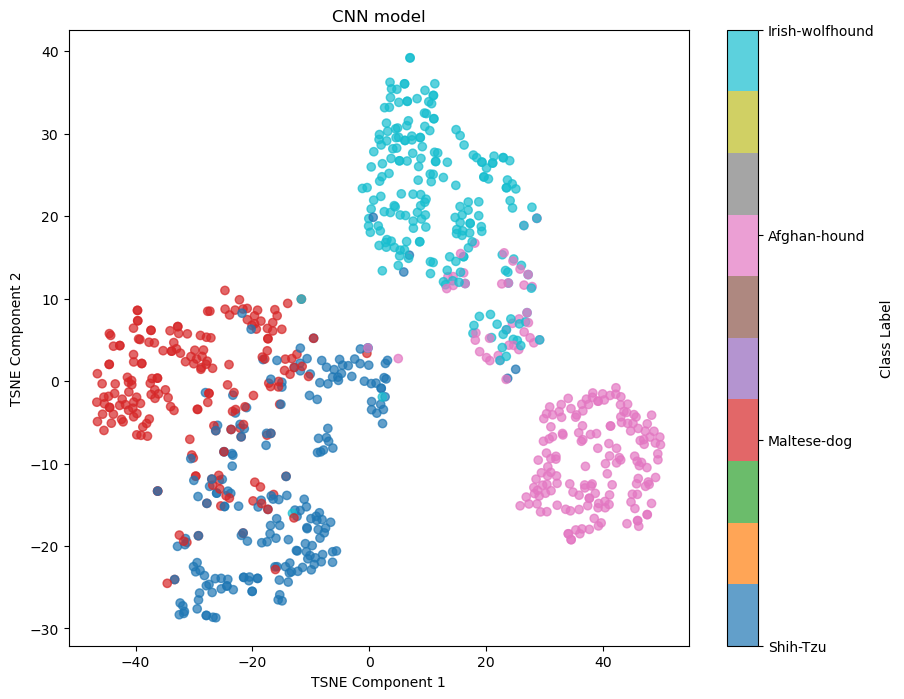

In [60]:
train_embeddings, train_labels = extract_embeddings(model, train_loader, device)

tsne = TSNE(n_components=2, random_state=42)
train_embeddings_2d = tsne.fit_transform(train_embeddings)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(train_embeddings_2d[:, 0], train_embeddings_2d[:, 1], c=train_labels, cmap='tab10', alpha=0.7)
cbar = plt.colorbar(scatter, label='Class Label')
cbar.set_ticks(range(len(CATEGORIES)))
cbar.set_ticklabels(CATEGORIES)
plt.title("CNN model")
plt.xlabel("TSNE Component 1")
plt.ylabel("TSNE Component 2")
plt.show()


In [12]:
from torchvision import models

resnet_model = models.resnet18(pretrained=True)

for parameter in resnet_model.parameters():
    parameter.requires_grad = False

resnet_model.fc = nn.Sequential(
    nn.Linear(resnet_model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, NUM_CLASSES)
)

resnet_model = resnet_model.to(device) 


loss_function = nn.CrossEntropyLoss()
optimizer_instance = optim.Adam(resnet_model.parameters(), lr=0.001)

log_directory = os.path.join("logs", "fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_writer = SummaryWriter(log_directory)

early_stopping_threshold = 3
minimum_validation_loss = float('inf')
stopping_counter = 0

C:\Users\HONOR\miniconda3\envs\workspace\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\HONOR\miniconda3\envs\workspace\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
for epoch_number in range(EPOCHS):
    resnet_model.train()
    total_training_loss = 0.0

    for batch_inputs, batch_labels in train_loader:
        batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)

        optimizer_instance.zero_grad()
        predictions = resnet_model(batch_inputs)
        loss_value = loss_function(predictions, batch_labels)
        loss_value.backward()
        optimizer_instance.step()

        total_training_loss += loss_value.item()

    resnet_model.eval()
    validation_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = resnet_model(val_inputs)
            loss_value = loss_function(val_outputs, val_labels)
            validation_loss += loss_value.item()

            _, predicted_classes = torch.max(val_outputs.data, 1)
            total_samples += val_labels.size(0)
            correct_predictions += (predicted_classes == val_labels).sum().item()

    average_training_loss = total_training_loss / len(train_loader)
    average_validation_loss = validation_loss / len(val_loader)
    validation_accuracy = correct_predictions / total_samples

    tensorboard_writer.add_scalar('Loss/train', average_training_loss, epoch_number)
    tensorboard_writer.add_scalar('Loss/val', average_validation_loss, epoch_number)
    tensorboard_writer.add_scalar('Accuracy/val', validation_accuracy, epoch_number)

    if average_validation_loss < minimum_validation_loss:
        minimum_validation_loss = average_validation_loss
        stopping_counter = 0
        torch.save(resnet_model.state_dict(), 'best_resnet_model.pth')
    else:
        stopping_counter += 1
        if stopping_counter >= early_stopping_threshold:
            print(f"Early stopping triggered at epoch {epoch_number}")
            break

    print(f"Epoch {epoch_number + 1}/{EPOCHS}, Training Loss: {average_training_loss:.4f}, Validation Loss: {average_validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

torch.save(resnet_model.state_dict(), 'resnet_model_final.pth')
tensorboard_writer.close()

Epoch 1/30, Training Loss: 1.2366, Validation Loss: 0.7972, Validation Accuracy: 0.7550
Epoch 2/30, Training Loss: 0.7677, Validation Loss: 0.6037, Validation Accuracy: 0.7900
Epoch 3/30, Training Loss: 0.5713, Validation Loss: 0.4372, Validation Accuracy: 0.8250
Epoch 4/30, Training Loss: 0.4666, Validation Loss: 0.4028, Validation Accuracy: 0.8250
Epoch 5/30, Training Loss: 0.4071, Validation Loss: 0.4185, Validation Accuracy: 0.8050
Epoch 6/30, Training Loss: 0.3934, Validation Loss: 0.3883, Validation Accuracy: 0.8000
Epoch 7/30, Training Loss: 0.3854, Validation Loss: 0.3896, Validation Accuracy: 0.8100
Epoch 8/30, Training Loss: 0.3510, Validation Loss: 0.4126, Validation Accuracy: 0.8100
Early stopping triggered at epoch 8


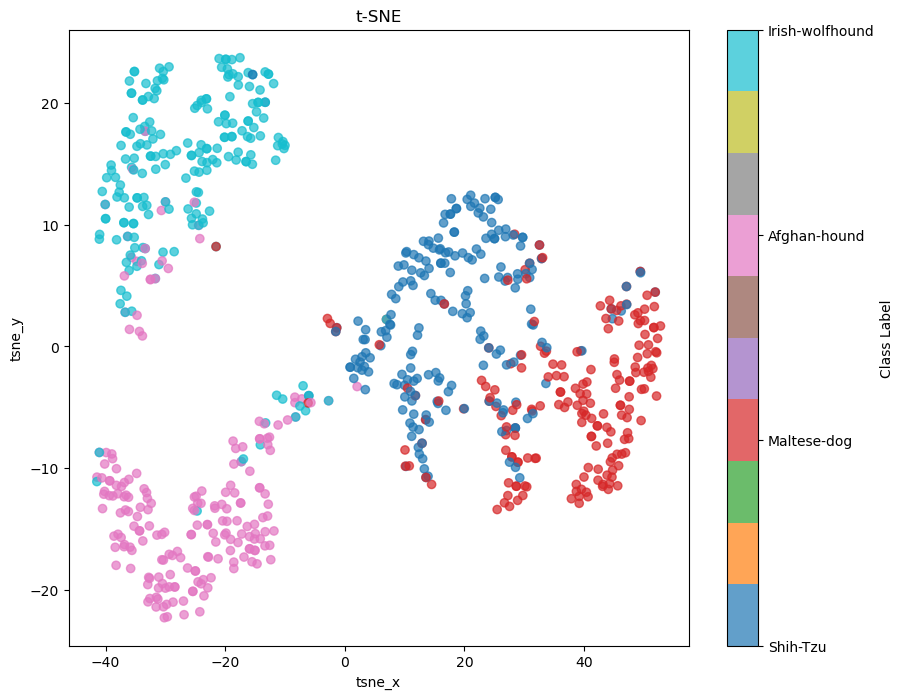

In [14]:
train_embeddings_resnet, train_labels_resnet = extract_embeddings(resnet_model, train_loader, device)
tsne_resnet = TSNE(n_components=2, random_state=42)
train_embeddings_2d_resnet = tsne_resnet.fit_transform(train_embeddings_resnet)

plt.figure(figsize=(10, 8))
scatter_resnet = plt.scatter(train_embeddings_2d_resnet[:, 0], train_embeddings_2d_resnet[:, 1], c=train_labels_resnet, cmap='tab10', alpha=0.7)
cbar_resnet = plt.colorbar(scatter_resnet, label='Class Label')
cbar_resnet.set_ticks(range(len(CATEGORIES)))
cbar_resnet.set_ticklabels(CATEGORIES)
plt.title("t-SNE")
plt.xlabel("tsne_x")
plt.ylabel("tsne_y")
plt.show()